In [164]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from alpha_vantage.timeseries import TimeSeries
# Technical indicator library
import talib as ta

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Alphavantage

In [3]:
app = TimeSeries('Y6J6TX17SSPPJALQ', output_format='pandas')

***

In [149]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2019-10-17', end='2021-10-17', interval = "1D")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)


    return df

In [150]:
aapl = get_finance_data('AAPL')

In [151]:
aapl

,Open,High,Low,Close,Volume
Date,,,,,
2019-10-17,57.823189,58.083908,57.437031,57.869923,67585200
2019-10-18,57.700209,58.435636,57.626420,58.147861,97433600
2019-10-21,58.420876,59.274364,58.371684,59.156300,87247200
2019-10-22,59.316173,59.571971,58.937389,59.021019,82293600
2019-10-23,59.547379,59.827776,59.330932,59.813015,75828800
...,...,...,...,...,...
2021-10-11,142.270004,144.809998,141.809998,142.809998,64452200
2021-10-12,143.229996,143.250000,141.039993,141.509995,73035900
2021-10-13,141.240005,141.399994,139.199997,140.910004,78762700


In [120]:
n = 10

In [121]:
aapl['RSI'] = ta.RSI(np.array(aapl['Close'].shift(1)), timeperiod=n)

In [122]:
aapl['SMA'] = aapl['Close'].shift(1).rolling(window=n).mean()

# Create a column by name, Corr and assign the calculation of correlation to it
aapl['Corr'] = aapl['Close'].shift(1).rolling(window=n).corr(aapl['SMA'].shift(1))

In [123]:
# Create a column by name, SAR and assign the SAR calculation to it
aapl['SAR'] = ta.SAR(np.array(aapl['High'].shift(1)), np.array(aapl['Low'].shift(1)),
                   0.2, 0.2)

# Create a column by name, ADX and assign the ADX calculation to it
aapl['ADX'] = ta.ADX(np.array(aapl['High'].shift(1)), np.array(aapl['Low'].shift(1)),
                   np.array(aapl['Open']), timeperiod=n)

In [124]:
# Create columns high, low and close with previous minute's OHLC data
aapl['Prev_High'] = aapl['High'].shift(1)
aapl['Prev_Low'] = aapl['Low'].shift(1)
aapl['Prev_Close'] = aapl['Close'].shift(1)

In [125]:
# Create columns 'OO' with the difference between the current minute's open and last minute's open
aapl['OO'] = aapl['Open']-aapl['Open'].shift(1)

# Create columns 'OC' with the difference between the current minute's open and last minute's close
aapl['OC'] = aapl['Open']-aapl['Prev_Close']

In [126]:
# Create a column 'Fut_Ret' with the calculation of returns
aapl['Fut_Ret'] = (aapl['Open'].shift(-1)-aapl['Open'])/aapl['Open']

# Create n columns and assign
for i in range(1, n):
    aapl['return%i' % i] = aapl['Fut_Ret'].shift(i)

In [127]:
# Change the value of 'Corr' to -1 if it is less than -1
aapl.loc[aapl['Corr'] < -1, 'Corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
aapl.loc[aapl['Corr'] > 1, 'Corr'] = 1

# Drop the NaN values
Df = aapl.dropna()

In [128]:
# Create a variable split that stores 80% of the length of the dataframe
t = .8
split = int(t*len(Df))
split

295

In [129]:
# Create a column by name, 'Signal' and initialize with 0
Df['Signal'] = 0

# Assign a value of 1 to 'Signal' column for the quantile with the highest returns
Df.loc[Df['Fut_Ret'] > Df['Fut_Ret'][:split].quantile(q=0.66), 'Signal'] = 1

# Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
Df.loc[Df['Fut_Ret'] < Df['Fut_Ret'][:split].quantile(q=0.34), 'Signal'] = -1

In [130]:
# Assign a value of 0 to 'Signal' column at 1529 time
Df.loc[(Df.index.hour == 16) & (Df.index.minute == 00), 'Signal'] = 0

# Assign a value of 0 to 'Fut_Ret' column at 1529 time
Df.loc[(Df.index.hour == 16) & (Df.index.minute == 00), 'Fut_Ret'] = 0

In [131]:
# Use drop method to drop the columns
X = Df.drop(['Close', 'Signal', 'High',
             'Low', 'Volume', 'Fut_Ret'], axis=1)

# Create a variable which contains all the 'Signal' values
y = Df['Signal']

In [132]:
# Create the 'steps' variable with the pipeline functions
steps = [('scaler', StandardScaler()), ('svc', SVC())]

# Pass the 'steps' to the Pipeline function
pipeline = Pipeline(steps)

In [133]:
# Test variables for 'c' and 'g'
c = [10, 100, 1000, 10000]
g = [1e-2, 1e-1, 1e0]

In [134]:
# Intialise the parameters
parameters = {'svc__C': c,
              'svc__gamma': g,
              'svc__kernel': ['rbf']
              }

In [135]:
# Call the RandomizedSearchCV function and pass the parameters
rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))

In [136]:
# Call the 'fit' method of rcv and pass the train data to it
rcv.fit(X.iloc[:split], y.iloc[:split])

# Call the 'best_params_' method to obtain the best parameters of C
best_C = rcv.best_params_['svc__C']

# Call the 'best_params_' method to obtain the best parameters of kernel
best_kernel = rcv.best_params_['svc__kernel']

# Call the 'best_params_' method to obtain the best parameters of gamma
best_gamma = rcv.best_params_['svc__gamma']

In [137]:
# Create a new SVC classifier
cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

In [138]:
# Instantiate the StandardScaler
ss1 = StandardScaler()

In [139]:
# Pass the scaled train data to the SVC classifier
cls.fit(ss1.fit_transform(X.iloc[:split]), y.iloc[:split])

SVC(C=100, gamma=0.01)

In [140]:
# Pass the test data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(X.iloc[split:]))

# Initiate a column by name, 'Pred_Signal' and assign 0 to it
Df['Pred_Signal'] = 0

In [141]:
# Save the predicted values for the train data
Df.iloc[:split, Df.columns.get_loc('Pred_Signal')] = pd.Series(
    cls.predict(ss1.transform(X.iloc[:split])).tolist())

# Save the predicted values for the test data
Df.iloc[split:, Df.columns.get_loc('Pred_Signal')] = y_predict

In [142]:
# Calculate strategy returns and store them in 'Ret1' column
Df['Ret1'] = Df['Fut_Ret']*Df['Pred_Signal']

In [143]:
# Calculate the confusion matrix
cm = confusion_matrix(y[split:], y_predict)
cm

array([[ 8,  2,  9],
       [15,  1, 12],
       [ 9,  2, 16]], dtype=int64)

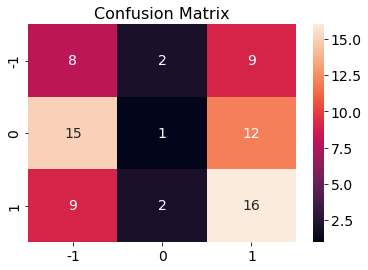

In [144]:
# Set the font sizes
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams.update({'font.size': 14})

# Plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

# Set the axis labels
ax.xaxis.set_ticklabels(['-1', '0', '1'])
ax.yaxis.set_ticklabels(['-1', '0', '1'])
plt.show()

In [145]:
# Calculate the classification report
cr = classification_report(y[split:], y_predict)
print(cr)

              precision    recall  f1-score   support

          -1       0.25      0.42      0.31        19
           0       0.20      0.04      0.06        28
           1       0.43      0.59      0.50        27

    accuracy                           0.34        74
   macro avg       0.29      0.35      0.29        74
weighted avg       0.30      0.34      0.29        74



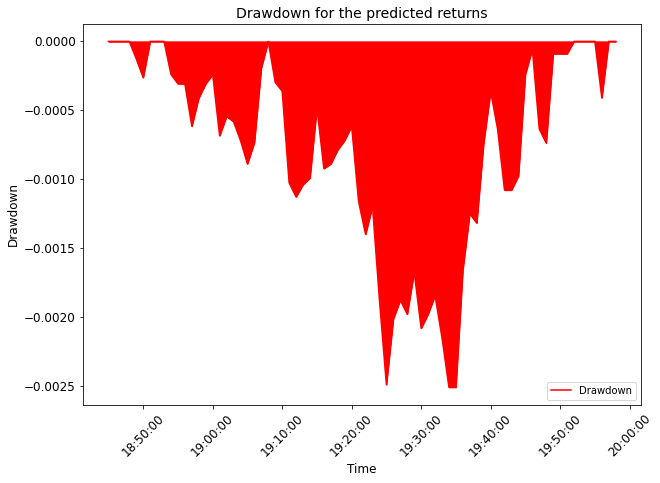

The maximum drawdown is -0.25%


In [146]:
"""
The drawdown metrics and plotting is performed here
"""
# Calculate the cumulative returns
cum_rets = (Df['Ret1'][split:]+1).cumprod()

# Calculate the running maximum
running_max = np.maximum.accumulate(cum_rets.dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1
drawdown.index = cum_rets.index

# Calculate the maximum drawdown
max_dd = drawdown.min()*100

# Plot the drawdown
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(drawdown, color='r')
ax.fill_between(drawdown.index, drawdown.values, color='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M:%S"))

# Set the font sizes
_ = plt.xticks(rotation=45)
plt.title('Drawdown for the predicted returns', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(labels=["Drawdown"], prop={'size': 10}, loc="lower right")

# Display the plot
plt.show()
print("The maximum drawdown is %.2f" % max_dd+"%")

In [147]:
# Calculate the annualised Sharpe ratio
sharpe = np.sqrt(252*6.25*60) * \
    Df['Ret1'][split:].mean() / Df['Ret1'][split:].std()

print("The annualised Sharpe ratio is %.2f" % sharpe)

The annualised Sharpe ratio is 29.93


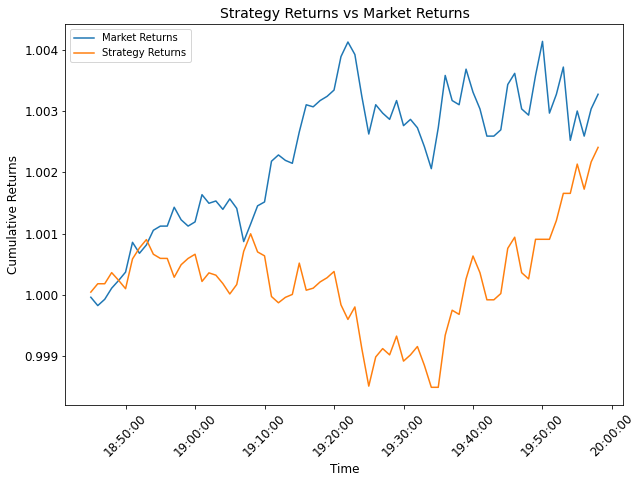

The strategy return is 0.24%


In [148]:
# Plotting the returns
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot((Df['Fut_Ret'][split:]+1).cumprod())
ax.plot((Df['Ret1'][split:]+1).cumprod())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M:%S"))
_ = plt.xticks(rotation=45)

# Setting the labels and font sizes
plt.title('Strategy Returns vs Market Returns', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(labels=["Market Returns", "Strategy Returns"],
          prop={'size': 10}, loc="upper left")
plt.show()


return_strategy = ((Df['Ret1'][split:]+1).cumprod().tail(1)[0]-1)*100
print("The strategy return is %.2f" % return_strategy + "%")

## Linear Regression

In [154]:
# Calculate 3-day moving average of close prices
aapl['S_3'] = aapl['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close prices
aapl['S_15'] = aapl['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close prices
aapl['S_60'] = aapl['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
aapl['Corr'] = aapl['Close'].shift(1).rolling(window=10).corr(aapl['S_3'].shift(1))

aapl['Std_U'] = aapl['High']-aapl['Open']
aapl['Std_D'] = aapl['Open']-aapl['Low']

aapl['OD'] = aapl['Open']-aapl['Open'].shift(1)
aapl['OL'] = aapl['Open']-aapl['Close'].shift(1)

aapl.tail()

,Open,High,Low,Close,Volume,S_3,S_15,S_60,Corr,Std_U,Std_D,OD,OL
Date,,,,,,,,,,,,,
2021-10-11,142.270004,144.809998,141.809998,142.809998,64452200,142.729996,143.244666,147.168940,0.386200,2.539993,0.460007,-1.759995,-0.629990
2021-10-12,143.229996,143.250000,141.039993,141.509995,73035900,142.999995,143.235999,147.112923,0.006085,0.020004,2.190002,0.959991,0.419998
2021-10-13,141.240005,141.399994,139.199997,140.910004,78762700,142.406662,143.107999,147.100808,0.014521,0.159988,2.040009,-1.989990,-0.269989
2021-10-14,142.110001,143.880005,141.509995,143.759995,69907100,141.743332,142.778665,147.017119,-0.244516,1.770004,0.600006,0.869995,1.199997
2021-10-15,143.770004,144.899994,143.509995,144.839996,67885200,142.059998,142.573998,146.993411,-0.248504,1.129990,0.260010,1.660004,0.010010


In [156]:
X = aapl[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr']]
X.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr
Date,,,,,,,
2021-10-11,142.270004,142.729996,143.244666,147.168940,-1.759995,-0.629990,0.386200
2021-10-12,143.229996,142.999995,143.235999,147.112923,0.959991,0.419998,0.006085
2021-10-13,141.240005,142.406662,143.107999,147.100808,-1.989990,-0.269989,0.014521
2021-10-14,142.110001,141.743332,142.778665,147.017119,0.869995,1.199997,-0.244516
2021-10-15,143.770004,142.059998,142.573998,146.993411,1.660004,0.010010,-0.248504


In [157]:
yU = aapl['Std_U']
yU.tail()

Date
2021-10-11    2.539993
2021-10-12    0.020004
2021-10-13    0.159988
2021-10-14    1.770004
2021-10-15    1.129990
Name: Std_U, dtype: float64

In [158]:
yD = aapl['Std_D']
yD.tail()

Date
2021-10-11    0.460007
2021-10-12    2.190002
2021-10-13    2.040009
2021-10-14    0.600006
2021-10-15    0.260010
Name: Std_D, dtype: float64

In [161]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('linear',LinearRegression())]     
pipeline = Pipeline(steps)

In [162]:
parameters = {'linear__fit_intercept':[0,1]}

In [165]:
reg = GridSearchCV(pipeline, parameters, cv=5)

In [166]:
t = .8
split = int(t*len(Df))
reg.fit(X[:split],yU[:split])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [167]:
best_fit = reg.best_params_['linear__fit_intercept']

In [168]:
reg = LinearRegression(fit_intercept=best_fit)

In [169]:
X = imp.fit_transform(X,yU)

In [172]:
reg.fit(X[:split], yU[:split])
yU_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the dataframe
aapl.reset_index(inplace=True)
aapl['Max_U'] = 0
aapl.loc[aapl.index >= split, 'Max_U'] = yU_predict
aapl.loc[aapl['Max_U'] < 0, 'Max_U'] = 0

In [175]:
reg = GridSearchCV(pipeline, parameters, cv=5)
reg.fit(X[:split], yD[:split])
best_fit = reg.best_params_['linear__fit_intercept']
reg = LinearRegression(fit_intercept=best_fit)
X = imp.fit_transform(X, yD)
reg.fit(X[:split], yD[:split])
yD_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the data frame
aapl['Max_D'] = 0
aapl.loc[aapl.index >= split, 'Max_D'] = yD_predict
aapl.loc[aapl['Max_D'] < 0, 'Max_D'] = 0

aapl.set_index('Date', inplace=True)

In [177]:
# We will use the predicted upside deviation values to calculate the high price
aapl['P_H'] = aapl['Open']+aapl['Max_U']
aapl['P_L'] = aapl['Open']-aapl['Max_D']

aapl[['High', 'P_H', 'Low', 'P_L']].tail()

,High,P_H,Low,P_L
Date,,,,
2021-10-11,144.809998,144.620717,141.809998,140.083625
2021-10-12,143.250000,145.287355,141.039993,140.911590
2021-10-13,141.399994,143.590131,139.199997,139.013621
2021-10-14,143.880005,144.163997,141.509995,139.717892
2021-10-15,144.899994,145.648493,143.509995,141.539105


In [178]:
# Trading signal
aapl['Signal'] = 0
aapl.loc[(aapl['High']>aapl['P_H']) &(aapl['Low']>aapl['P_L']),'Signal'] = -1
aapl.loc[(aapl['High']<aapl['P_H']) &(aapl['Low']<aapl['P_L']),'Signal'] = 1

# Compute GLD returns 
aapl['Ret'] = (aapl['Close']-aapl['Close'].shift(1))/aapl['Close'].shift(1)

# Compute strategy returns(
aapl['Ret1'] = aapl['Ret']*(aapl['Signal'].shift(1))

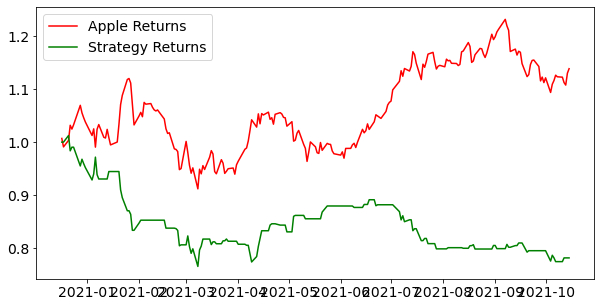

In [181]:
plt.figure(figsize=(10,5))
plt.plot(((aapl['Ret'][split:]+1).cumprod()),color='r',label='Apple Returns')
plt.plot(((aapl['Ret1'][split:]+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()

In [180]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = Df['Ret1'][split:] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe -7.870602368419231


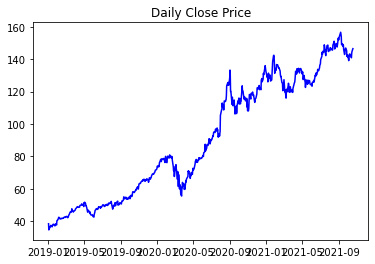

In [86]:
plt.plot(aapl['Close'], color='blue')
plt.title("Daily Close Price")
plt.show()

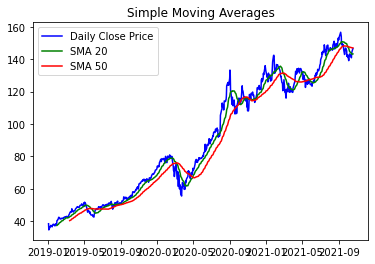

In [87]:

aapl['SMA_20'] = ta.SMA(aapl['Close'], timeperiod=20)
aapl['SMA_50'] = ta.SMA(aapl['Close'], timeperiod=50)

plt.plot(aapl['Close'], color='blue', label='Daily Close Price')
plt.plot(aapl['SMA_20'], color='green', label='SMA 20')
plt.plot(aapl['SMA_50'], color='red', label='SMA 50')
plt.legend()
plt.title('Simple Moving Averages')
plt.show()

In [88]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50
Date,,,,,,,,,
2019-01-02,37.645785,38.608258,37.485372,38.382221,148158800,0.0,0.0,NaN,NaN
2019-01-03,34.994130,35.417035,34.512895,34.559074,365248800,0.0,0.0,NaN,NaN
2019-01-04,35.127804,36.104860,34.950380,36.034374,234428400,0.0,0.0,NaN,NaN
2019-01-07,36.141315,36.172912,35.460778,35.954166,219111200,0.0,0.0,NaN,NaN
2019-01-08,36.350336,36.899628,36.097567,36.639565,164101200,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-10-12,143.229996,143.250000,141.039993,141.509995,73035900,0.0,0.0,143.843498,147.271393
2021-10-13,141.240005,141.399994,139.199997,140.910004,78762700,0.0,0.0,143.437498,147.146803
2021-10-14,142.110001,143.880005,141.509995,143.759995,69907100,0.0,0.0,143.185999,147.087399


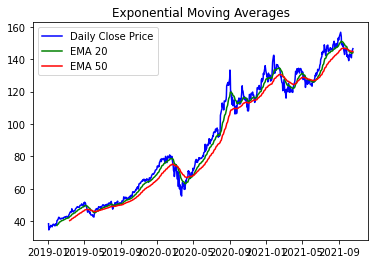

In [89]:
aapl['EMA_20'] = ta.EMA(aapl['Close'], timeperiod=20)
aapl['EMA_50'] = ta.EMA(aapl['Close'], timeperiod=50)

plt.plot(aapl['Close'], color='blue', label='Daily Close Price')
plt.plot(aapl['EMA_20'], color='green', label='EMA 20')
plt.plot(aapl['EMA_50'], color='red', label='EMA 50')
plt.legend()
plt.title('Exponential Moving Averages')
plt.show()

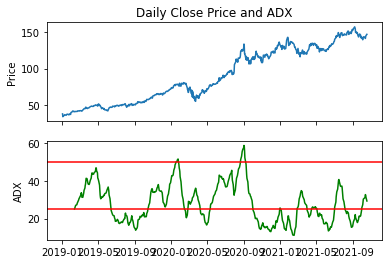

In [90]:
aapl['ADX'] = ta.ADX(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(aapl['Close'])
ax2.set_ylabel('ADX')
ax2.plot(aapl['ADX'], color='green')
ax1.set_title('Daily Close Price and ADX')
ax2.axhline(y = 50, color = 'r', linestyle = '-')
ax2.axhline(y = 25, color = 'r', linestyle = '-')
plt.show()

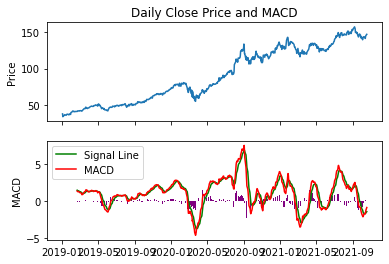

In [91]:
macd, macdsignal, macdhist = ta.MACD(aapl['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(aapl['Close'])
ax2.set_ylabel('MACD')
ax2.plot(macdsignal, color='green', label='Signal Line')
ax2.plot(macd, color='red', label='MACD')
ax2.bar(macdhist.index, macdhist, color='purple')
ax1.set_title('Daily Close Price and MACD')
plt.legend()
plt.show()

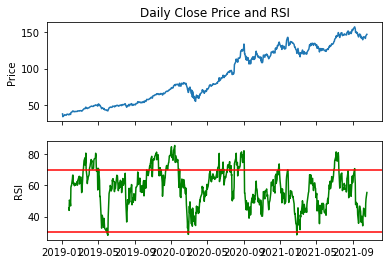

In [92]:

aapl['RSI'] = ta.RSI(aapl['Close'], timeperiod=14)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(aapl['Close'])
ax2.set_ylabel('RSI')
ax2.plot(aapl['RSI'], color='green')
ax2.axhline(y = 70, color = 'r', linestyle = '-')
ax2.axhline(y = 30, color = 'r', linestyle = '-')
ax1.set_title('Daily Close Price and RSI')
plt.show()

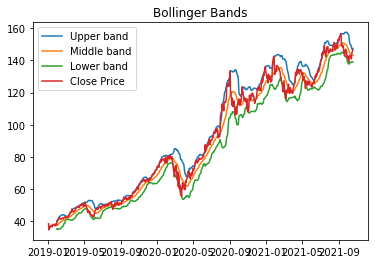

In [93]:
upper, mid, lower = ta.BBANDS(aapl['Close'], nbdevup=2, nbdevdn=2, timeperiod=20)
plt.plot(upper, label="Upper band")
plt.plot(mid, label='Middle band')
plt.plot(lower, label='Lower band')
plt.plot(aapl['Close'], label='Close Price')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

In [94]:
aapl['Corr_20'] = aapl['Close'].shift(1).rolling(window=20).corr(['SMA_20'].shift(1))

AttributeError: 'list' object has no attribute 'shift'

In [ ]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,EMA_20,EMA_50,ADX,RSI
Date,,,,,,,,,,,,,
2019-01-02,37.645788,38.608262,37.485375,38.382225,148158800,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,34.994130,35.417035,34.512895,34.559074,365248800,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,35.127808,36.104864,34.950384,36.034378,234428400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,36.141322,36.172920,35.460786,35.954174,219111200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,36.350340,36.899632,36.097571,36.639568,164101200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-12,143.229996,143.250000,141.039993,141.509995,73035900,0.0,0.0,143.843498,147.271393,143.969474,144.922200,31.636420,41.390628
2021-10-13,141.240005,141.399994,139.199997,140.910004,78762700,0.0,0.0,143.437498,147.146803,143.678095,144.764859,32.692084,40.070774
2021-10-14,142.110001,143.880005,141.509995,143.759995,69907100,0.0,0.0,143.185999,147.087399,143.685895,144.725453,32.175413,48.475459


In [ ]:
# Create columns high, low and close with previous minute's OHLC data
aapl['Prev_High'] = aapl['High'].shift(1)
aapl['Prev_Low'] = aapl['Low'].shift(1)
aapl['Prev_Close'] = aapl['Close'].shift(1)
# Create columns 'OO' with the difference between the current minute's open and last minute's open
aapl['OO'] = aapl['Open']-aapl['Open'].shift(1)

# Create columns 'OC' with the difference between the current minute's open and last minute's close
aapl['OC'] = aapl['Open']-aapl['Prev_Close']

In [ ]:
# Create a column 'Fut_Ret' with the calculation of returns
aapl['Fut_Ret'] = (aapl['Open'].shift(-1)-aapl['Open'])/aapl['Open']

# Create n columns and assign
for i in range(1, 5):
    aapl['return%i' % i] = aapl['Fut_Ret'].shift(i)

In [ ]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,EMA_20,...,Prev_High,Prev_Low,Prev_Close,OO,OC,Fut_Ret,return1,return2,return3,return4
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,37.645788,38.608262,37.485375,38.382225,148158800,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.070437,NaN,NaN,NaN,NaN
2019-01-03,34.994130,35.417035,34.512895,34.559074,365248800,0.0,0.0,NaN,NaN,NaN,...,38.608262,37.485375,38.382225,-2.651659,-3.388095,0.003820,-0.070437,NaN,NaN,NaN
2019-01-04,35.127808,36.104864,34.950384,36.034378,234428400,0.0,0.0,NaN,NaN,NaN,...,35.417035,34.512895,34.559074,0.133678,0.568734,0.028852,0.003820,-0.070437,NaN,NaN
2019-01-07,36.141322,36.172920,35.460786,35.954174,219111200,0.0,0.0,NaN,NaN,NaN,...,36.104864,34.950384,36.034378,1.013515,0.106944,0.005783,0.028852,0.003820,-0.070437,NaN
2019-01-08,36.350340,36.899632,36.097571,36.639568,164101200,0.0,0.0,NaN,NaN,NaN,...,36.172920,35.460786,35.954174,0.209017,0.396166,0.011567,0.005783,0.028852,0.003820,-0.070437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-12,143.229996,143.250000,141.039993,141.509995,73035900,0.0,0.0,143.843498,147.271393,143.969474,...,144.809998,141.809998,142.809998,0.959991,0.419998,-0.013894,0.006748,-0.012220,0.006780,0.025740
2021-10-13,141.240005,141.399994,139.199997,140.910004,78762700,0.0,0.0,143.437498,147.146803,143.678095,...,143.250000,141.039993,141.509995,-1.989990,-0.269989,0.006160,-0.013894,0.006748,-0.012220,0.006780
2021-10-14,142.110001,143.880005,141.509995,143.759995,69907100,0.0,0.0,143.185999,147.087399,143.685895,...,141.399994,139.199997,140.910004,0.869995,1.199997,0.011681,0.006160,-0.013894,0.006748,-0.012220


In [ ]:
# Change the value of 'Corr' to -1 if it is less than -1
aapl.loc[aapl['Corr'] < -1, 'Corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
aapl.loc[aapl['Corr'] > 1, 'Corr'] = 1

# Drop the NaN values
aapl = aapl.dropna()

KeyError: 'Corr'